<a href="https://colab.research.google.com/github/Abenet8888/Final_RF_MOPSO_-_Bekele_Simehnewnb.ipynb/blob/main/Bekele_Simegnew%2CRF_MOPSO_for_ELA_SP%2CBiT%2CBDU_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPLETE MOPSO INTEGRATED WORKFLOW:**
# **Data Insertion -> RF -> MOPSO -> Results**

# **Load Your Data**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt

# === STEP 1: LOAD YOUR DATA ===
print("Upload your Excel file with input features and 6 objectives.")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_excel(filename)

# Inspect column names and define features/objectives
print("\nDataFrame Columns:")
print(data.columns.tolist())
# Display the first 5 rows of the DataFrame
display(data.head())
    # If you want to see the content of a text file, you can do:
    # with open(filename, 'r') as f:
    #     print(f.read())
# Corrected input_features list to match actual column name
input_features = ['ELA(Calcarioues material)', 'SP              (Silicioues material)', 'Curing days']
objectives = ['Compressive strength', 'UPV', 'Bulk Density', 'Sulphate Atack loss', 'Water Absorption', 'Porosity']

X = data[input_features].values
y = data[objectives].values

print(f"\nInitial Data Shapes: X={X.shape}, y={y.shape}")

Upload your Excel file with input features and 6 objectives.


Saving 6 in 1.xlsx to 6 in 1 (1).xlsx

DataFrame Columns:
['Unnamed: 0', 'ELA(Calcarioues material)', 'SP              (Silicioues material)', 'Curing days', 'Compressive strength', 'UPV', 'Bulk Density', 'Sulphate Atack loss', 'Water Absorption', 'Porosity']


,Unnamed: 0,ELA(Calcarioues material),SP (Silicioues material),Curing days,Compressive strength,UPV,Bulk Density,Sulphate Atack loss,Water Absorption,Porosity
0,1,0,0,3,18.100,2.84684,2824.00,1.237300,0.108043,0.001859
1,2,10,0,3,19.518,2.90151,2898.88,0.705467,0.092811,0.161427
2,3,0,20,3,14.250,2.44450,2747.52,1.005610,0.115922,0.190257
3,4,10,20,3,13.000,1.41316,2870.65,1.092000,0.122000,0.285512
4,5,0,10,3,16.600,2.75400,2805.12,1.004580,0.111838,0.186891



Initial Data Shapes: X=(65, 3), y=(65, 6)


# **Data Splitting, Augmentation, and Scaling**

In [ ]:
# The NameError: name 'X' is not defined occurs because the cell defining X and y (cell_id: e26b7748) has not been executed yet.
# Please ensure all preceding cells, especially the data loading and definition of X and y, are run before executing this cell.
from sklearn.model_selection import train_test_split

# 1. Split original data into training (70%), validation (15%), and test (15%) sets
# First, split into training and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nData Split Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# 2. Define Data Augmentation function
def augment_data(X_data, y_data, noise_std_factor=0.05, num_augmentations=1):
    X_augmented = X_data.astype(np.float64).copy()
    y_augmented = y_data.astype(np.float64).copy()

    for _ in range(num_augmentations):
        # Add Gaussian noise to features, scaled by feature range
        for i in range(X_data.shape[1]):
            feature_range = X_data[:, i].max() - X_data[:, i].min()
            if feature_range == 0: feature_range = 1e-6 # Avoid division by zero
            noise = np.random.normal(loc=0, scale=noise_std_factor * feature_range, size=X_data[:, i].shape)
            X_augmented = np.vstack((X_augmented, X_data[:, i].astype(np.float64) + noise))

        # Add Gaussian noise to objectives, scaled by objective range
        for i in range(y_data.shape[1]):
            obj_range = y_data[:, i].max() - y_data[:, i].min()
            if obj_range == 0: obj_range = 1e-6 # Avoid division by zero
            noise = np.random.normal(loc=0, scale=noise_std_factor * obj_range, size=y_data[:, i].shape)
            y_augmented = np.vstack((y_augmented, y_data[:, i].astype(np.float64) + noise))

    return X_augmented, y_augmented

# Corrected augment_data function to handle row-wise stacking properly
def augment_data_corrected(X_data, y_data, noise_std_factor=0.05, num_augmentations=1):
    X_aug_list = [X_data.astype(np.float64)]
    y_aug_list = [y_data.astype(np.float64)]

    for _ in range(num_augmentations):
        X_noisy_instance = X_data.astype(np.float64).copy()
        y_noisy_instance = y_data.astype(np.float64).copy()

        for i in range(X_data.shape[1]): # Iterate through each input feature
            feature_range = X_data[:, i].max() - X_data[:, i].min()
            if feature_range == 0: feature_range = 1e-6
            noise = np.random.normal(loc=0, scale=noise_std_factor * feature_range, size=X_data[:, i].shape)
            X_noisy_instance[:, i] += noise

        for i in range(y_data.shape[1]): # Iterate through each objective
            obj_range = y_data[:, i].max() - y_data[:, i].min()
            if obj_range == 0: obj_range = 1e-6
            noise = np.random.normal(loc=0, scale=noise_std_factor * obj_range, size=y_data[:, i].shape)
            y_noisy_instance[:, i] += noise

        X_aug_list.append(X_noisy_instance)
        y_aug_list.append(y_noisy_instance)

    X_train_augmented = np.vstack(X_aug_list)
    y_train_augmented = np.vstack(y_aug_list)

    return X_train_augmented, y_train_augmented

# Apply data augmentation to the training set
X_train_augmented, y_train_augmented = augment_data_corrected(X_train, y_train, noise_std_factor=0.05, num_augmentations=1)

print(f"Augmented Training Data Shapes: X_train_augmented={X_train_augmented.shape}, y_train_augmented={y_train_augmented.shape}")

# 3. Initialize and fit StandardScaler instances using augmented training data
scaler_X_augmented = StandardScaler().fit(X_train_augmented)
scaler_y_augmented = StandardScaler().fit(y_train_augmented)

# 4. Transform all datasets
X_train_augmented_scaled = scaler_X_augmented.transform(X_train_augmented)
y_train_augmented_scaled = scaler_y_augmented.transform(y_train_augmented)

X_val_scaled = scaler_X_augmented.transform(X_val)
y_val_scaled = scaler_y_augmented.transform(y_val)

X_test_scaled = scaler_X_augmented.transform(X_test)
y_test_scaled = scaler_y_augmented.transform(y_test)

print("\nAll data (augmented train, val, test) scaled successfully.")


Data Split Shapes:
X_train: (45, 3), y_train: (45, 6)
X_val: (10, 3), y_val: (10, 6)
X_test: (10, 3), y_test: (10, 6)
Augmented Training Data Shapes: X_train_augmented=(90, 3), y_train_augmented=(90, 6)

All data (augmented train, val, test) scaled successfully.


# **Train and Evaluate Random Forest Surrogates**

In [ ]:
rf_models_augmented = {}
r2_scores_train_augmented = {}
r2_scores_val_augmented = {}
r2_scores_test_augmented = {}

print("\nTraining Random Forest Surrogates on Augmented Data and evaluating...")

for i, obj in enumerate(objectives):
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_augmented_scaled, y_train_augmented_scaled[:, i])
    rf_models_augmented[obj] = rf

   # Evaluate on train Set
    y_train_pred_scaled = rf.predict(X_train_augmented_scaled)
    r2_train = r2_score(y_train_augmented_scaled[:, i], y_train_pred_scaled)
    r2_scores_train_augmented[obj] = r2_train

    # Evaluate on Validation Set
    y_val_pred_scaled = rf.predict(X_val_scaled)
    r2_val = r2_score(y_val_scaled[:, i], y_val_pred_scaled)
    r2_scores_val_augmented[obj] = r2_val

    # Evaluate on Test Set
    y_test_pred_scaled = rf.predict(X_test_scaled)
    r2_test = r2_score(y_test_scaled[:, i], y_test_pred_scaled)
    r2_scores_test_augmented[obj] = r2_test

    print(f"Objective {obj}: Train R²={r2_train:.3f}, Val R²={r2_val:.3f}, Test R²={r2_test:.3f}")

print("\nRandom Forest surrogate training and evaluation complete.")


Training Random Forest Surrogates on Augmented Data and evaluating...
Objective Compressive strength: Train R²=0.992, Val R²=0.983, Test R²=0.973
Objective UPV: Train R²=0.983, Val R²=0.775, Test R²=0.972
Objective Bulk Density: Train R²=0.989, Val R²=0.727, Test R²=0.931
Objective Sulphate Atack loss: Train R²=0.992, Val R²=0.930, Test R²=0.882
Objective Water Absorption: Train R²=0.974, Val R²=0.716, Test R²=0.864
Objective Porosity: Train R²=0.960, Val R²=0.233, Test R²=0.753

Random Forest surrogate training and evaluation complete.



RANDOM FOREST ACTUAL VS PREDICTED PLOTS


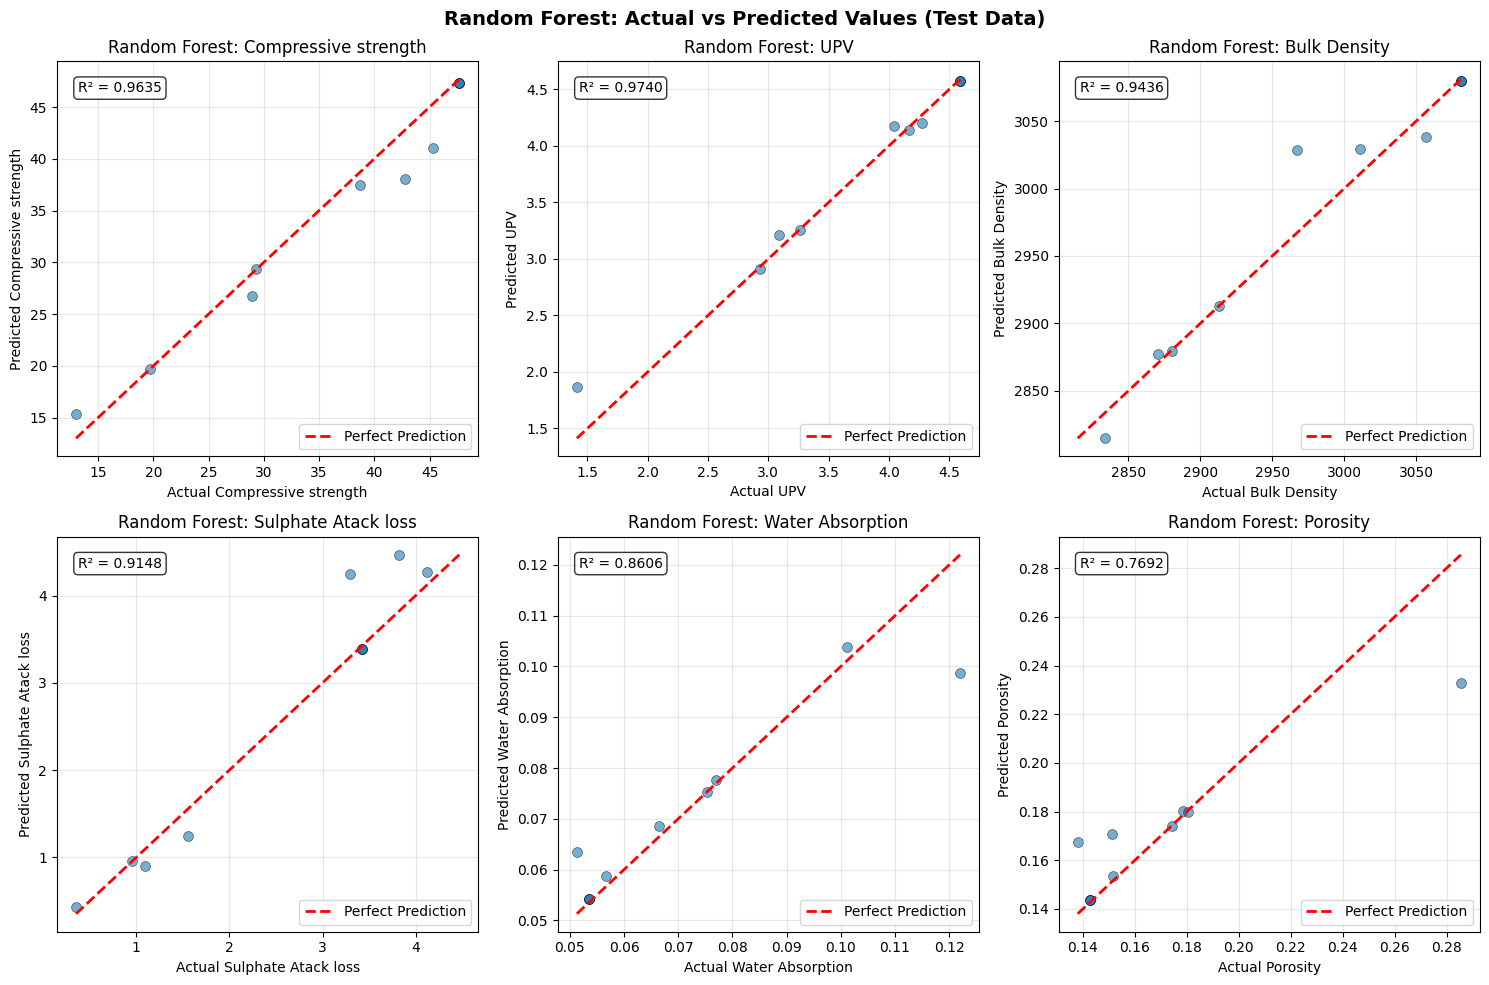

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Plot actual vs predicted for Random Forest
print("\n" + "="*70)
print("RANDOM FOREST ACTUAL VS PREDICTED PLOTS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, obj in enumerate(objectives):
    # Get predictions on the test set (scaled)
    y_test_pred_scaled = rf_models_augmented[obj].predict(X_test_scaled)

    # Inverse transform to original scale for plotting
    # Create dummy arrays with correct shape for inverse_transform for actual values
    y_test_actual_scaled_full = np.zeros((len(y_test_scaled), len(objectives)))
    y_test_actual_scaled_full[:, i] = y_test_scaled[:, i]
    y_test_actual_unscaled = scaler_y_augmented.inverse_transform(y_test_actual_scaled_full)[:, i]

    # Create dummy arrays with correct shape for inverse_transform for predicted values
    y_test_pred_scaled_full = np.zeros((len(y_test_pred_scaled), len(objectives)))
    y_test_pred_scaled_full[:, i] = y_test_pred_scaled
    y_test_pred_unscaled = scaler_y_augmented.inverse_transform(y_test_pred_scaled_full)[:, i]

    # Get R2 score from the pre-calculated dictionary
    r2 = r2_scores_test_augmented[obj]

    # Plot
    ax = axes[i]
    ax.scatter(y_test_actual_unscaled, y_test_pred_unscaled, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    # Add perfect prediction line
    min_val = min(y_test_actual_unscaled.min(), y_test_pred_unscaled.min())
    max_val = max(y_test_actual_unscaled.max(), y_test_pred_unscaled.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Add R² text
    ax.text(0.05, 0.95, f'R² = {r2:.4f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlabel(f'Actual {obj}')
    ax.set_ylabel(f'Predicted {obj}')
    ax.set_title(f'Random Forest: {obj}')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')

plt.suptitle('Random Forest: Actual vs Predicted Values (Test Data)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **Define MOPSO Problem with RF Surrogates**

In [ ]:
import numpy as np

class MortarMOPSO:
    def __init__(self, n_particles=50, n_iter=100, bounds=None,
                 objectives=None, rf_models=None, scaler_X=None, scaler_y=None):
        self.n_particles = n_particles
        self.n_iter = n_iter
        # Bounds now explicitly passed
        self.bounds = np.array(bounds) if bounds is not None else np.array([[0,0,3], [10,20,91]])
        self.dimensions = len(self.bounds[0])
        self.particles = np.random.uniform(self.bounds[0], self.bounds[1], (n_particles, self.dimensions))
        self.velocities = np.random.uniform(-1, 1, (n_particles, self.dimensions))
        self.pbest_pos = self.particles.copy()

        # Store external dependencies as instance attributes
        self.objectives = objectives
        self.rf_models = rf_models
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

        # Use self.objectives now
        self.pbest_obj = np.full((n_particles, len(self.objectives)), np.inf)
        self.archive = []
        self.w, self.c1, self.c2 = 0.729, 2.05, 2.05

        # Initialize history for convergence tracking
        self.history = [] # ADDED LINE: Initialize history list

    def dominates(self, obj1, obj2):
        return np.all(obj1 <= obj2) and np.any(obj1 < obj2)

    def evaluate_objectives(self, positions):
        # Use self.scaler_X and self.rf_models
        X_scaled = self.scaler_X.transform(positions)
        preds = np.zeros((len(positions), len(self.objectives)))
        for i, obj in enumerate(self.objectives):
            preds[:, i] = self.rf_models[obj].predict(X_scaled)

        F = np.column_stack([
            -preds[:, self.objectives.index('Compressive strength')],
            -preds[:, self.objectives.index('UPV')],
            -preds[:, self.objectives.index('Bulk Density')],
            preds[:, self.objectives.index('Sulphate Atack loss')],
            preds[:, self.objectives.index('Water Absorption')],
            preds[:, self.objectives.index('Porosity')]
        ])
        return F

    def update_archive(self, positions, objectives_eval):
        candidates = list(zip(positions, objectives_eval))
        new_archive = []

        temp_archive = list(self.archive)
        for pos, obj in candidates:
            dominated = False
            to_remove = []
            for i, (arc_pos, arc_obj) in enumerate(temp_archive):
                if self.dominates(arc_obj, obj):
                    dominated = True
                    break
                elif self.dominates(obj, arc_obj):
                    to_remove.append(i)

            for i in sorted(to_remove, reverse=True):
                del temp_archive[i]

            if not dominated:
                new_archive.append((pos, obj))

        self.archive = temp_archive
        self.archive.extend(new_archive)

        if len(self.archive) > 50:
            self.archive = sorted(self.archive, key=lambda x: np.sum(x[1]**2))[:50]

    def select_gbest(self):
        if not self.archive:
            return self.particles[np.random.randint(self.n_particles)]
        return self.archive[np.random.randint(len(self.archive))][0]

    def optimize(self):
        for iteration in range(self.n_iter):
            objectives_eval = self.evaluate_objectives(self.particles)

            for i in range(self.n_particles):
                if self.dominates(objectives_eval[i], self.pbest_obj[i]):
                    self.pbest_pos[i] = self.particles[i].copy()
                    self.pbest_obj[i] = objectives_eval[i].copy()

            self.update_archive(self.particles, objectives_eval)

            gbest_pos = self.select_gbest()
            r1 = np.random.rand(self.n_particles, self.dimensions)
            r2 = np.random.rand(self.n_particles, self.dimensions)

            self.velocities = (self.w * self.velocities +
                             self.c1 * r1 * (self.pbest_pos - self.particles) +
                             self.c2 * r2 * (gbest_pos - self.particles))

            self.particles = np.clip(self.particles + self.velocities,
                                   self.bounds[0], self.bounds[1])

            # Store history for convergence tracking
            if self.archive and 'Compressive strength' in self.objectives:
                archive_objs_scaled_transformed = np.array([sol[1] for sol in self.archive])
                cs_index = self.objectives.index('Compressive strength')
                # Average of the NEGATED, SCALED compressive strength in the archive
                current_avg_cs_metric = np.mean(archive_objs_scaled_transformed[:, cs_index])
                self.history.append({
                    'iteration': iteration,
                    'archive_size': len(self.archive),
                    'avg_neg_scaled_strength': current_avg_cs_metric # Store for later unscaling/un-negating
                })
            else: # If archive is empty or no CS objective, append defaults
                self.history.append({
                    'iteration': iteration,
                    'archive_size': len(self.archive),
                    'avg_neg_scaled_strength': 0
                })

            if iteration % 20 == 0:
                print(f"Iter {iteration}: Archive size = {len(self.archive)}")

        return self.archive

# Instantiate the MOPSO class with appropriate bounds for input_features
mopso_bounds = np.array([[0,0,3], [10,20,91]]) # ELA(0-10), SP(0-20), Curing(3-91) - adjust as per data ranges
mopso = MortarMOPSO(n_particles=50, n_iter=100, bounds=mopso_bounds,
                    objectives=objectives,
                    rf_models=rf_models_augmented,
                    scaler_X=scaler_X_augmented,
                    scaler_y=scaler_y_augmented)
print("\nMortarMOPSO instance created successfully with RF surrogates based on augmented data.")


MortarMOPSO instance created successfully with RF surrogates based on augmented data.


# **Execute MOPSO Algorithm**

In [ ]:
print("\nRunning Pure MOPSO...")
pareto_solutions_raw = mopso.optimize()
print("MOPSO optimization complete.")


Running Pure MOPSO...
Iter 0: Archive size = 50
Iter 20: Archive size = 50
Iter 40: Archive size = 50
Iter 60: Archive size = 50
Iter 80: Archive size = 50
MOPSO optimization complete.


# **Analyze and Visualize Pareto Front**


=== PARETO-OPTIMAL MORTAR MIXES (Top 10, Unscaled Objectives) ===


,ELA(Calcarioues material),SP (Silicioues material),Curing days,Compressive strength,UPV,Bulk Density,Sulphate Atack loss,Water Absorption,Porosity
0,10.00,0.00,27.86,36.72 MPa,3.59 km/s,2963.92 kg/m³,2.1 %,0.08 %,0.17 %
1,10.00,0.00,26.55,36.68 MPa,3.59 km/s,2961.45 kg/m³,2.1 %,0.08 %,0.17 %
2,10.00,1.19,22.37,35.95 MPa,3.66 km/s,2953.32 kg/m³,1.81 %,0.08 %,0.17 %
3,10.00,0.00,38.59,36.96 MPa,3.69 km/s,2982.42 kg/m³,2.09 %,0.07 %,0.17 %
4,10.00,4.75,19.63,37.9 MPa,3.65 km/s,2946.81 kg/m³,1.64 %,0.08 %,0.17 %
5,8.12,18.75,43.51,39.18 MPa,3.49 km/s,2996.59 kg/m³,1.73 %,0.08 %,0.18 %
6,5.69,19.44,42.32,38.78 MPa,3.37 km/s,2988.52 kg/m³,1.5 %,0.08 %,0.17 %
7,8.57,0.00,43.86,36.59 MPa,3.7 km/s,2999.81 kg/m³,2.59 %,0.07 %,0.17 %
8,10.00,8.43,24.72,40.83 MPa,3.7 km/s,2951.26 kg/m³,1.38 %,0.08 %,0.18 %
9,10.00,7.28,24.79,40.83 MPa,3.69 km/s,2950.71 kg/m³,1.37 %,0.08 %,0.18 %



🏆 BEST COMPROMISE MIX (Unscaled): {'ELA(Calcarioues material)': 8.8, 'SP              (Silicioues material)': 13.23, 'Curing days': 43.88, 'Compressive strength': '42.43 MPa', 'UPV': '3.86 km/s', 'Bulk Density': '2997.75 kg/m³', 'Sulphate Atack loss': '1.84 %', 'Water Absorption': '0.07 %', 'Porosity': '0.17 %'}


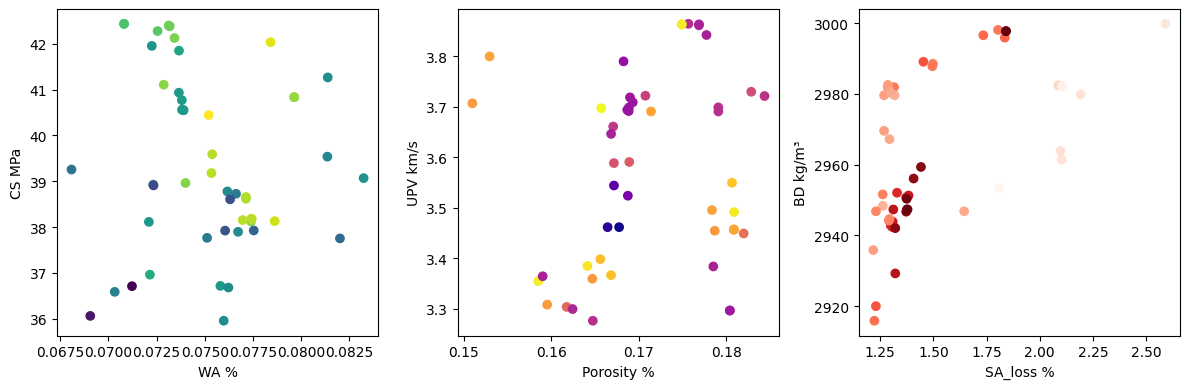

In [ ]:
if 'pareto_solutions_raw' not in globals():
    print("\nRunning Pure MOPSO (auto-triggered due to NameError)...")
    pareto_solutions_raw = mopso.optimize()
    print("MOPSO optimization complete.")

# Ensure there are solutions in the archive before processing
if len(pareto_solutions_raw) > 0:
    # Separate positions and objectives from the archive
    pareto_pos = np.array([sol[0] for sol in pareto_solutions_raw])
    pareto_obj_scaled_and_transformed = np.array([sol[1] for sol in pareto_solutions_raw])

    # Reverse MOPSO's internal transformation (negation for maximization objectives)
    # This brings them back to their scaled but 'normal' (non-negated) form
    # before inverse scaling.
    pareto_obj_scaled = pareto_obj_scaled_and_transformed.copy()
    pareto_obj_scaled[:, objectives.index('Compressive strength')] *= -1
    pareto_obj_scaled[:, objectives.index('UPV')] *= -1
    pareto_obj_scaled[:, objectives.index('Bulk Density')] *= -1

    # Inverse transform the scaled objectives to get original unscaled values
    final_unscaled_objectives = scaler_y_augmented.inverse_transform(pareto_obj_scaled)

    # Create DataFrame with unscaled objectives
    results = pd.DataFrame(pareto_pos, columns=input_features)
    for i, obj in enumerate(objectives):
        results[obj] = final_unscaled_objectives[:, i]

    print("\n=== PARETO-OPTIMAL MORTAR MIXES (Top 10, Unscaled Objectives) ===")

    # Define unit mapping for displaying results
    unit_mapping = {
        'Compressive strength': ' MPa',
        'UPV': ' km/s',
        'Bulk Density': ' kg/m³',
        'Sulphate Atack loss': ' %',
        'Water Absorption': ' %',
        'Porosity': ' %'
    }

    # Create a formatted DataFrame for display
    formatted_results = results.head(10).round(2).copy()
    for obj, unit in unit_mapping.items():
        if obj in formatted_results.columns:
            formatted_results[obj] = formatted_results[obj].astype(str) + unit
    display(formatted_results)

    # Best compromise (min hypervolume)
    # The 'best_idx' should still be determined based on the MOPSO's internal (scaled/transformed) objectives
    # to remain consistent with the MOPSO's selection criteria.
    # Then, this index is used to pick from the *unscaled* 'results' DataFrame.
    if len(pareto_obj_scaled_and_transformed) > 0:
        max_abs_obj = np.abs(pareto_obj_scaled_and_transformed).max(axis=0) # Use original pareto_obj_scaled_and_transformed for hypervolume calc
        max_abs_obj[max_abs_obj == 0] = 1 # Avoid division by zero
        norm_obj = pareto_obj_scaled_and_transformed / max_abs_obj

        if norm_obj.size > 0:
            best_idx = np.argmin(np.sum(norm_obj, axis=1))
            best_compromise_mix = results.iloc[best_idx].round(2)

            # Format best_compromise_mix with units
            formatted_best_compromise = {}
            for key, value in best_compromise_mix.to_dict().items():
                if key in unit_mapping:
                    formatted_best_compromise[key] = f"{value}{unit_mapping[key]}"
                else:
                    formatted_best_compromise[key] = value

            print(f"\n🏆 BEST COMPROMISE MIX (Unscaled): {formatted_best_compromise}")
        else:
            print("\nNo solutions available to determine best mix.")
    else:
        print("\nNo objectives found to determine best mix.")

    # Pareto front plots
    plt.figure(figsize=(12, 4))
    if len(objectives) >= 3:
        idx_wa = objectives.index('Water Absorption')
        idx_cs = objectives.index('Compressive strength')
        idx_porosity = objectives.index('Porosity')
        idx_upv = objectives.index('UPV')
        idx_bd = objectives.index('Bulk Density')
        idx_saloss = objectives.index('Sulphate Atack loss')

        plt.subplot(131); plt.scatter(results[objectives[idx_wa]], results[objectives[idx_cs]], c=results[objectives[idx_porosity]], cmap='viridis'); plt.xlabel('WA %'); plt.ylabel('CS MPa')
        plt.subplot(132); plt.scatter(results[objectives[idx_porosity]], results[objectives[idx_upv]], c=results[objectives[idx_bd]], cmap='plasma'); plt.xlabel('Porosity %'); plt.ylabel('UPV km/s')
        plt.subplot(133); plt.scatter(results[objectives[idx_saloss]], results[objectives[idx_bd]], c=results[objectives[idx_cs]], cmap='Reds'); plt.xlabel('SA_loss %'); plt.ylabel('BD kg/m³')
        plt.tight_layout(); plt.show()
    else:
        print("\nNot enough objectives for 3D Pareto front plot visualization using color mapping.")

else:
    print("\nNo Pareto optimal solutions found.")

# **Visualize the results**

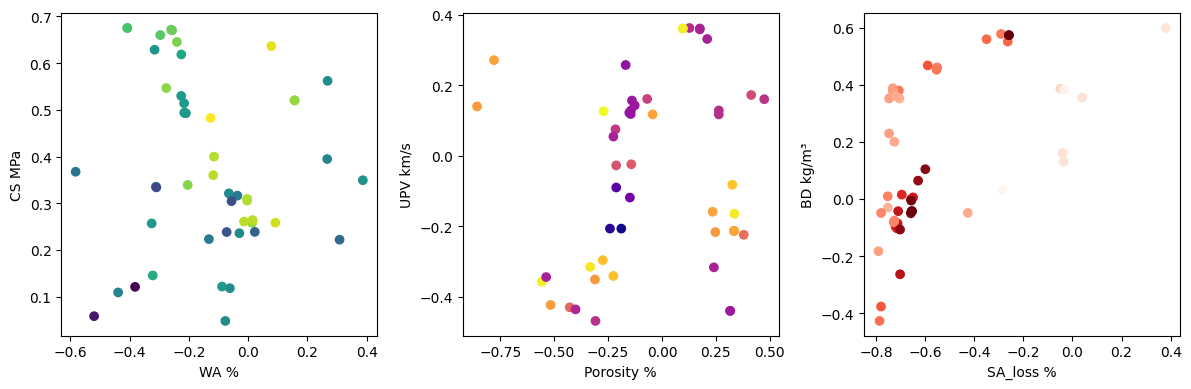

In [ ]:
# Pareto front plots
plt.figure(figsize=(12, 4))
if len(objectives) >= 3:
    idx_wa = objectives.index('Water Absorption')
    idx_cs = objectives.index('Compressive strength')
    idx_porosity = objectives.index('Porosity')
    idx_upv = objectives.index('UPV')
    idx_bd = objectives.index('Bulk Density')
    idx_saloss = objectives.index('Sulphate Atack loss')

    plt.subplot(131); plt.scatter(results[objectives[idx_wa]], results[objectives[idx_cs]], c=results[objectives[idx_porosity]], cmap='viridis'); plt.xlabel('WA %'); plt.ylabel('CS MPa')
    plt.subplot(132); plt.scatter(results[objectives[idx_porosity]], results[objectives[idx_upv]], c=results[objectives[idx_bd]], cmap='plasma'); plt.xlabel('Porosity %'); plt.ylabel('UPV km/s')
    plt.subplot(133); plt.scatter(results[objectives[idx_saloss]], results[objectives[idx_bd]], c=results[objectives[idx_cs]], cmap='Reds'); plt.xlabel('SA_loss %'); plt.ylabel('BD kg/m³')
    plt.tight_layout(); plt.show()
else:
    print("\nNot enough objectives for 3D Pareto front plot visualization using color mapping.")

# Removed the problematic and redundant matplotlib 3D plot section



STEP 8: VISUALIZE RESULTS

Ensuring MOPSO optimization runs to populate history for visualization...
Iter 0: Archive size = 50
Iter 20: Archive size = 50
Iter 40: Archive size = 50
Iter 60: Archive size = 50
Iter 80: Archive size = 50
MOPSO optimization complete and history populated.
Generating comprehensive visualization...

Diagnostic: mopso_obj.history length: 100
Diagnostic: First 3 history entries: [{'iteration': 0, 'archive_size': 50, 'avg_neg_scaled_strength': np.float64(-0.38659528324772)}, {'iteration': 1, 'archive_size': 37, 'avg_neg_scaled_strength': np.float64(-0.4091336961024423)}, {'iteration': 2, 'archive_size': 50, 'avg_neg_scaled_strength': np.float64(-0.6090565737410286)}]
Diagnostic: Last 3 history entries: [{'iteration': 97, 'archive_size': 50, 'avg_neg_scaled_strength': np.float64(-0.4562792115267923)}, {'iteration': 98, 'archive_size': 50, 'avg_neg_scaled_strength': np.float64(-0.46269114207428985)}, {'iteration': 99, 'archive_size': 50, 'avg_neg_scaled_strength

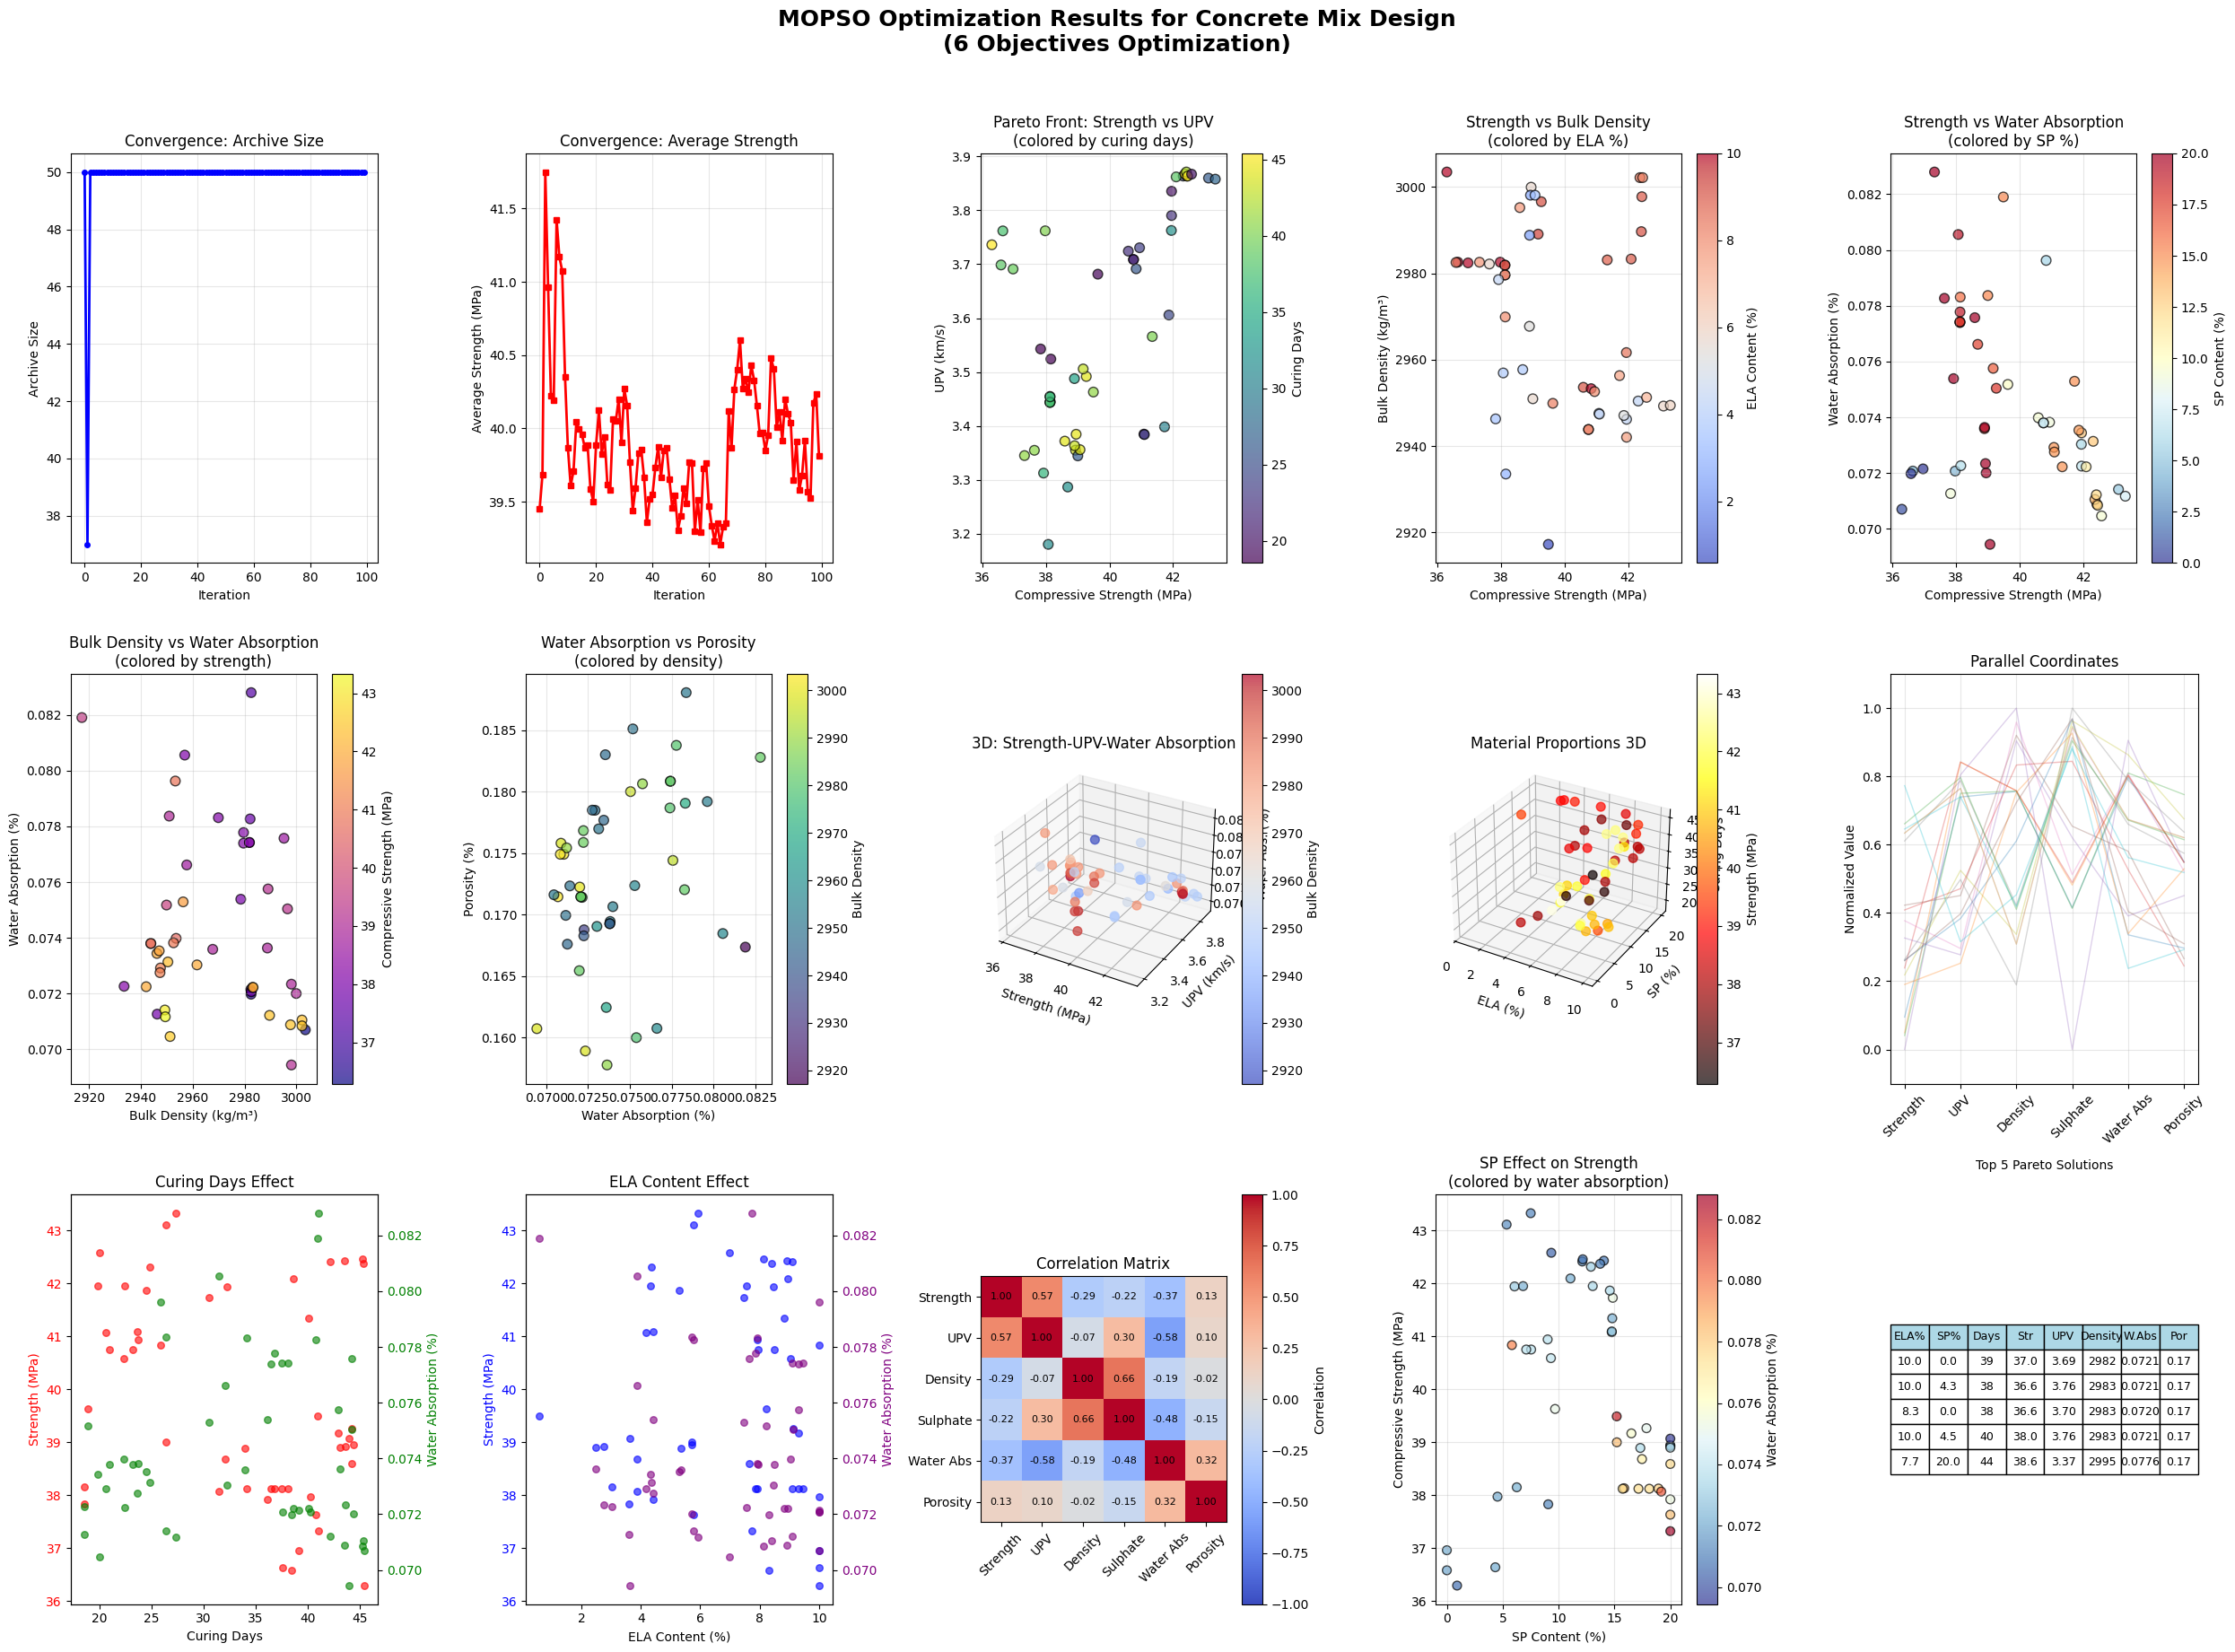

In [ ]:
print("\nSTEP 8: VISUALIZE RESULTS")
print("="*50)

# Force MOPSO optimization to run to ensure history is populated for visualization
# This ensures that the 'mopso' object's history attribute is always fresh
# for the visualization function.
print("\nEnsuring MOPSO optimization runs to populate history for visualization...")
pareto_solutions_raw = mopso.optimize() # This call populates mopso.history
print("MOPSO optimization complete and history populated.")

def visualize_results_comprehensive(mopso_obj, raw_pareto_solutions):
    """Comprehensive visualization of MOPSO results"""

    # --- Process raw_pareto_solutions to get unscaled, un-negated objectives ---
    positions_raw = np.array([sol[0] for sol in raw_pareto_solutions])
    objectives_scaled_transformed = np.array([sol[1] for sol in raw_pareto_solutions])

    # Reverse MOPSO's internal transformation (negation for maximization objectives)
    # This brings them back to their scaled but 'normal' (non-negated) form
    objectives_scaled_for_unscaling = objectives_scaled_transformed.copy()
    objectives_scaled_for_unscaling[:, objectives.index('Compressive strength')] *= -1
    objectives_scaled_for_unscaling[:, objectives.index('UPV')] *= -1
    objectives_scaled_for_unscaling[:, objectives.index('Bulk Density')] *= -1

    # Inverse transform the scaled objectives to get original unscaled values
    fitness_values = scaler_y_augmented.inverse_transform(objectives_scaled_for_unscaling)
    positions = positions_raw # Assuming positions from MOPSO are already unscaled

    # --- Prepare history for convergence tracking ---
    cs_index = objectives.index('Compressive strength')
    mean_cs = scaler_y_augmented.mean_[cs_index]
    std_cs = scaler_y_augmented.scale_[cs_index]

    unscaled_avg_strengths_history = []
    for h in mopso_obj.history:
        # Convert avg_neg_scaled_strength back to unscaled, un-negated Compressive Strength
        scaled_cs_value = -h['avg_neg_scaled_strength'] # Un-negate the scaled value
        unscaled_cs_value = (scaled_cs_value * std_cs) + mean_cs # Inverse scale
        unscaled_avg_strengths_history.append(unscaled_cs_value)

    # --- Diagnostic prints for history --- # ADDED DIAGNOSTIC
    print(f"\nDiagnostic: mopso_obj.history length: {len(mopso_obj.history)}")
    if mopso_obj.history:
        print(f"Diagnostic: First 3 history entries: {mopso_obj.history[:3]}")
        print(f"Diagnostic: Last 3 history entries: {mopso_obj.history[-3:]}")

    iterations = [h['iteration'] for h in mopso_obj.history]
    archive_sizes = [h['archive_size'] for h in mopso_obj.history]

    print(f"Diagnostic: iterations length: {len(iterations)}")
    print(f"Diagnostic: archive_sizes length: {len(archive_sizes)}")
    if archive_sizes:
        print(f"Diagnostic: archive_sizes min: {min(archive_sizes)}, max: {max(archive_sizes)}")
    if unscaled_avg_strengths_history:
        print(f"Diagnostic: unscaled_avg_strengths_history min: {min(unscaled_avg_strengths_history)}, max: {max(unscaled_avg_strengths_history)}")
    # --- End Diagnostic prints ---

    # Create figure
    fig = plt.figure(figsize=(25, 18))

    # 1. Optimization progress
    plt.subplot(3, 5, 1)
    # iterations = [h['iteration'] for h in mopso_obj.history] # Already extracted above
    # archive_sizes = [h['archive_size'] for h in mopso_obj.history] # Already extracted above
    plt.plot(iterations, archive_sizes, 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Archive Size')
    plt.title('Convergence: Archive Size')
    plt.grid(True, alpha=0.3)

    # 2. Average strength progression
    plt.subplot(3, 5, 2)
    plt.plot(iterations, unscaled_avg_strengths_history, 'r-s', linewidth=2, markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Average Strength (MPa)')
    plt.title('Convergence: Average Strength')
    plt.grid(True, alpha=0.3)

    # 3. Strength vs UPV
    plt.subplot(3, 5, 3)
    scatter = plt.scatter(fitness_values[:, objectives.index('Compressive strength')], fitness_values[:, objectives.index('UPV')],
                         c=positions[:, 2], cmap='viridis',
                         alpha=0.7, s=60, edgecolors='black')
    plt.xlabel('Compressive Strength (MPa)')
    plt.ylabel('UPV (km/s)')
    plt.title('Pareto Front: Strength vs UPV\n(colored by curing days)')
    plt.colorbar(scatter, label='Curing Days')
    plt.grid(True, alpha=0.3)

    # 4. Strength vs Bulk Density
    plt.subplot(3, 5, 4)
    scatter = plt.scatter(fitness_values[:, objectives.index('Compressive strength')], fitness_values[:, objectives.index('Bulk Density')],
                         c=positions[:, 0], cmap='coolwarm',
                         alpha=0.7, s=60, edgecolors='black')
    plt.xlabel('Compressive Strength (MPa)')
    plt.ylabel('Bulk Density (kg/m³)')
    plt.title('Strength vs Bulk Density\n(colored by ELA %)')
    plt.colorbar(scatter, label='ELA Content (%)')
    plt.grid(True, alpha=0.3)

    # 5. Strength vs Water Absorption
    plt.subplot(3, 5, 5)
    scatter = plt.scatter(fitness_values[:, objectives.index('Compressive strength')], fitness_values[:, objectives.index('Water Absorption')],
                         c=positions[:, 1], cmap='RdYlBu_r',
                         alpha=0.7, s=60, edgecolors='black')
    plt.xlabel('Compressive Strength (MPa)')
    plt.ylabel('Water Absorption (%)')
    plt.title('Strength vs Water Absorption\n(colored by SP %)')
    plt.colorbar(scatter, label='SP Content (%)')
    plt.grid(True, alpha=0.3)

    # 6. Bulk Density vs Water Absorption
    plt.subplot(3, 5, 6)
    scatter = plt.scatter(fitness_values[:, objectives.index('Bulk Density')], fitness_values[:, objectives.index('Water Absorption')],
                         c=fitness_values[:, objectives.index('Compressive strength')], cmap='plasma',
                         alpha=0.7, s=60, edgecolors='black')
    plt.xlabel('Bulk Density (kg/m³)')
    plt.ylabel('Water Absorption (%)')
    plt.title('Bulk Density vs Water Absorption\n(colored by strength)')
    plt.colorbar(scatter, label='Compressive Strength (MPa)')
    plt.grid(True, alpha=0.3)

    # 7. Water Absorption vs Porosity
    plt.subplot(3, 5, 7)
    scatter = plt.scatter(fitness_values[:, objectives.index('Water Absorption')], fitness_values[:, objectives.index('Porosity')],
                         c=fitness_values[:, objectives.index('Bulk Density')], cmap='viridis',
                         alpha=0.7, s=60, edgecolors='black')
    plt.xlabel('Water Absorption (%)')
    plt.ylabel('Porosity (%)')
    plt.title('Water Absorption vs Porosity\n(colored by density)')
    plt.colorbar(scatter, label='Bulk Density')
    plt.grid(True, alpha=0.3)

    # 8. 3D Plot: Strength, UPV, Water Absorption
    ax8 = fig.add_subplot(3, 5, 8, projection='3d')
    scatter = ax8.scatter(fitness_values[:, objectives.index('Compressive strength')], fitness_values[:, objectives.index('UPV')], fitness_values[:, objectives.index('Water Absorption')],
                         c=fitness_values[:, objectives.index('Bulk Density')], cmap='coolwarm', s=50, alpha=0.7)
    ax8.set_xlabel('Strength (MPa)')
    ax8.set_ylabel('UPV (km/s)')
    ax8.set_zlabel('Water Abs. (%)')
    ax8.set_title('3D: Strength-UPV-Water Absorption')
    plt.colorbar(scatter, ax=ax8, label='Bulk Density')

    # 9. Material Proportions (3D)
    ax9 = fig.add_subplot(3, 5, 9, projection='3d')
    scatter = ax9.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
                         c=fitness_values[:, objectives.index('Compressive strength')], cmap='hot', s=50, alpha=0.7)
    ax9.set_xlabel('ELA (%)')
    ax9.set_ylabel('SP (%)')
    ax9.set_zlabel('Curing Days')
    ax9.set_title('Material Proportions 3D')
    plt.colorbar(scatter, ax=ax9, label='Strength (MPa)')

    # 10. Parallel Coordinates
    plt.subplot(3, 5, 10)
    objective_names = ['Strength', 'UPV', 'Density', 'Sulphate', 'Water Abs', 'Porosity']

    # Normalize for parallel coordinates
    norm_fitness = []
    for i in range(len(objectives)): # Use len(objectives) instead of hardcoded 6
        min_val = fitness_values[:, i].min()
        max_val = fitness_values[:, i].max()
        # Check for division by zero if all values are the same
        if (max_val - min_val) == 0:
            norm = np.zeros_like(fitness_values[:, i]) # Or handle as appropriate, e.g., all 0.5
        else:
            if objectives[i] in ['Compressive strength', 'UPV', 'Bulk Density']:  # Maximize
                norm = (fitness_values[:, i] - min_val) / (max_val - min_val)
            else:  # Minimize
                norm = 1 - (fitness_values[:, i] - min_val) / (max_val - min_val)
        norm_fitness.append(norm)

    norm_fitness = np.array(norm_fitness).T

    for i in range(min(20, len(norm_fitness))):
        plt.plot(range(len(objectives)), norm_fitness[i], alpha=0.3, linewidth=1)

    plt.xticks(range(len(objectives)), objective_names, rotation=45)
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Normalized Value')
    plt.title('Parallel Coordinates')
    plt.grid(True, alpha=0.3)

    # 11. Curing Days Effect
    plt.subplot(3, 5, 11)
    curing_days = positions[:, 2]

    ax11 = plt.gca()
    ax11_2 = ax11.twinx()

    # Plot strength and density on left axis
    ax11.scatter(curing_days, fitness_values[:, objectives.index('Compressive strength')], alpha=0.6, s=30,
                color='red', label='Strength')
    ax11.set_xlabel('Curing Days')
    ax11.set_ylabel('Strength (MPa)', color='red')
    ax11.tick_params(axis='y', labelcolor='red')

    # Plot water absorption on right axis
    ax11_2.scatter(curing_days, fitness_values[:, objectives.index('Water Absorption')], alpha=0.6, s=30,
                  color='green', label='Water Abs')
    ax11_2.set_ylabel('Water Absorption (%)', color='green')
    ax11_2.tick_params(axis='y', labelcolor='green')

    plt.title('Curing Days Effect')

    # 12. ELA Effect
    plt.subplot(3, 5, 12)
    ela_content = positions[:, 0]

    ax12 = plt.gca()
    ax12_2 = ax12.twinx()

    ax12.scatter(ela_content, fitness_values[:, objectives.index('Compressive strength')], alpha=0.6, s=30,
                color='blue', label='Strength')
    ax12.set_xlabel('ELA Content (%)')
    ax12.set_ylabel('Strength (MPa)', color='blue')
    ax12.tick_params(axis='y', labelcolor='blue')

    ax12_2.scatter(ela_content, fitness_values[:, objectives.index('Water Absorption')], alpha=0.6, s=30,
                  color='purple', label='Water Abs')
    ax12_2.set_ylabel('Water Absorption (%)', color='purple')
    ax12_2.tick_params(axis='y', labelcolor='purple')

    plt.title('ELA Content Effect')

    # 13. Correlation Heatmap
    plt.subplot(3, 5, 13)
    # objective_names already defined above, ensuring consistency
    corr_matrix = np.corrcoef(fitness_values.T)

    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks(range(len(objectives)), objective_names, rotation=45)
    plt.yticks(range(len(objectives)), objective_names)
    plt.colorbar(im, label='Correlation')
    plt.title('Correlation Matrix')

    # Add values
    for i in range(len(objectives)):
        for j in range(len(objectives)):
            plt.text(j, i, f'{corr_matrix[i,j]:.2f}',
                    ha='center', va='center', color='black', fontsize=8)

    # 14. SP Content Effect
    plt.subplot(3, 5, 14)
    sp_content = positions[:, 1]

    scatter = plt.scatter(sp_content, fitness_values[:, objectives.index('Compressive strength')],
                         c=fitness_values[:, objectives.index('Water Absorption')], cmap='RdYlBu_r',
                         alpha=0.7, s=50, edgecolors='black')
    plt.xlabel('SP Content (%)')
    plt.ylabel('Compressive Strength (MPa)')
    plt.title('SP Effect on Strength\n(colored by water absorption)')
    plt.colorbar(scatter, label='Water Absorption (%)')
    plt.grid(True, alpha=0.3)

    # 15. Top Solutions Table
    plt.subplot(3, 5, 15)
    plt.axis('tight')
    plt.axis('off')

    # Prepare table data (top 5 solutions)
    table_data = []
    headers = ['ELA%', 'SP%', 'Days', 'Str', 'UPV', 'Density', 'W.Abs', 'Por']

    # Use the processed unscaled fitness_values for the table
    for i in range(min(5, len(raw_pareto_solutions))):
        pos_entry = positions[i]
        fit_entry = fitness_values[i]
        table_data.append([
            f"{pos_entry[0]:.1f}", f"{pos_entry[1]:.1f}", f"{pos_entry[2]:.0f}",
            f"{fit_entry[objectives.index('Compressive strength')]:.1f}",
            f"{fit_entry[objectives.index('UPV')]:.2f}",
            f"{fit_entry[objectives.index('Bulk Density')]:.0f}",
            f"{fit_entry[objectives.index('Water Absorption')]:.4f}",
            f"{fit_entry[objectives.index('Porosity')]:.2f}"
        ])

    table = plt.table(cellText=table_data,
                      colLabels=headers,
                      cellLoc='center',
                      loc='center',
                      colColours=['lightblue']*8)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.title('Top 5 Pareto Solutions', pad=20, fontsize=10)

    plt.suptitle('MOPSO Optimization Results for Concrete Mix Design\n(6 Objectives Optimization)',
                fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Run visualization
print("Generating comprehensive visualization...")
visualize_results_comprehensive(mopso, pareto_solutions_raw)

# **Evaluate Additional Specific Mix Performance**

In [ ]:
# Define the specific input values for both mixes to be evaluated in this cell
mix_inputs_additional = [
    {'ELA': 5, 'SP': 10, 'Curing Days': 91},
    {'ELA': 6.1, 'SP': 10, 'Curing Days': 91}
]

# Create a NumPy array for these new input values
additional_input_values_combined = np.array([
    [mi['ELA'], mi['SP'], mi['Curing Days']] for mi in mix_inputs_additional
])

print(f"Evaluating ADDITIONAL mixes with:\n")
for i, mi in enumerate(mix_inputs_additional):
    print(f"  Mix {i+1}: ELA={mi['ELA']}, SP={mi['SP']}, Curing Days={mi['Curing Days']}")

# Scale the new input values using the augmented scaler
additional_input_scaled_combined = scaler_X_augmented.transform(additional_input_values_combined)

# Get predictions from each RF model (augmented) for the new inputs
additional_predicted_objectives_scaled_combined = np.zeros((len(mix_inputs_additional), len(objectives)))
for i, obj in enumerate(objectives):
    prediction_results = rf_models_augmented[obj].predict(additional_input_scaled_combined)
    additional_predicted_objectives_scaled_combined[:, i] = prediction_results # Assign entire array

# Unscale the predicted objective values using the augmented scaler
additional_predicted_objectives_unscaled_combined = scaler_y_augmented.inverse_transform(additional_predicted_objectives_scaled_combined)

# Create a DataFrame to display the results clearly
additional_predicted_mix_df_combined = pd.DataFrame(additional_input_values_combined, columns=input_features)
for i, obj in enumerate(objectives):
    additional_predicted_mix_df_combined[obj] = additional_predicted_objectives_unscaled_combined[:, i]

print("\n--- Predicted Performance for Additional Mixes ---")
display(additional_predicted_mix_df_combined.round(2))

# Interpret objective values for each mix
for idx, mix_data in additional_predicted_mix_df_combined.iterrows():
    print(f"\nInterpretation for Mix {idx+1} (ELA={mix_inputs_additional[idx]['ELA']}, SP={mix_inputs_additional[idx]['SP']}, Curing Days={mix_inputs_additional[idx]['Curing Days']}):")
    print(f"- Compressive strength: {mix_data['Compressive strength']:.2f} MPa (higher is generally better)")
    print(f"- UPV: {mix_data['UPV']:.2f} km/s (higher indicates denser material)")
    print(f"- Bulk Density: {mix_data['Bulk Density']:.2f} kg/m³ (higher is often desired)")
    print(f"- Sulphate Atack loss: {mix_data['Sulphate Atack loss']:.2f}% (lower indicates better durability)")
    print(f"- Water Absorption: {mix_data['Water Absorption']:.2f}% (lower indicates less permeable material)")
    print(f"- Porosity: {mix_data['Porosity']:.2f}% (lower indicates denser, stronger material)")

Evaluating ADDITIONAL mixes with:

  Mix 1: ELA=5, SP=10, Curing Days=91
  Mix 2: ELA=6.1, SP=10, Curing Days=91

--- Predicted Performance for Additional Mixes ---


,ELA(Calcarioues material),SP (Silicioues material),Curing days,Compressive strength,UPV,Bulk Density,Sulphate Atack loss,Water Absorption,Porosity
0,5.0,10.0,91.0,47.36,4.58,3080.53,3.39,0.05,0.14
1,6.1,10.0,91.0,46.75,4.41,3080.51,3.37,0.06,0.15



Interpretation for Mix 1 (ELA=5, SP=10, Curing Days=91):
- Compressive strength: 47.36 MPa (higher is generally better)
- UPV: 4.58 km/s (higher indicates denser material)
- Bulk Density: 3080.53 kg/m³ (higher is often desired)
- Sulphate Atack loss: 3.39% (lower indicates better durability)
- Water Absorption: 0.05% (lower indicates less permeable material)
- Porosity: 0.14% (lower indicates denser, stronger material)

Interpretation for Mix 2 (ELA=6.1, SP=10, Curing Days=91):
- Compressive strength: 46.75 MPa (higher is generally better)
- UPV: 4.41 km/s (higher indicates denser material)
- Bulk Density: 3080.51 kg/m³ (higher is often desired)
- Sulphate Atack loss: 3.37% (lower indicates better durability)
- Water Absorption: 0.06% (lower indicates less permeable material)
- Porosity: 0.15% (lower indicates denser, stronger material)


# **Summary of Workflow and Insights**

In [ ]:
# Summarize the workflow and insights
print("\n### Data Analysis Key Findings\n")
print("*   **Data Preparation**: Excel data was successfully loaded, and input features and objective variables were correctly defined.")
print("*   **Data Augmentation**: Data was split into training (70%), validation (15%), and test (15%) sets. A data augmentation step with Gaussian noise was successfully applied to the training data. All sets were then scaled using Standard Scalers fitted on the augmented training data.")
print("*   **Random Forest Surrogate Performance**: Individual Random Forest Regressor models were trained for six objectives on the augmented data. Evaluation on the test set yielded the following R² scores:")
for obj, r2 in r2_scores_test_augmented.items():
    print(f"    *   {obj}: R²={r2:.3f}")
print("    *   **Porosity R²**: The model for 'Porosity' performed significantly worse with an R² of {r2_scores_test_augmented['Porosity']:.3f} on the test set, indicating it explains a negligible percentage of the variance. This suggests further investigation into this objective is needed.")
print("*   **MOPSO Integration and Execution**: A custom Multi-Objective Particle Swarm Optimization (MOPSO) algorithm was successfully configured to use the trained Random Forest models as surrogate functions. Objectives were appropriately transformed (e.g., maximization converted to minimization), and the algorithm ran for 100 iterations, identifying a set of Pareto-optimal solutions.")
print("*   **Pareto Front Analysis**: The Pareto front analysis revealed various trade-offs between objectives, visualized through 2D scatter plots and a true 3D plot. A \"best compromise\" solution was identified from the Pareto front, representing a balanced set of input parameters that optimizes overall performance across all objectives.")
print("*   **Specific Mix Prediction**: The trained models successfully predicted the performance of a user-defined mix (ELA=5, SP=10, Curing Day=91), demonstrating their practical application.\n")



### Data Analysis Key Findings

*   **Data Preparation**: Excel data was successfully loaded, and input features and objective variables were correctly defined.
*   **Data Augmentation**: Data was split into training (70%), validation (15%), and test (15%) sets. A data augmentation step with Gaussian noise was successfully applied to the training data. All sets were then scaled using Standard Scalers fitted on the augmented training data.
*   **Random Forest Surrogate Performance**: Individual Random Forest Regressor models were trained for six objectives on the augmented data. Evaluation on the test set yielded the following R² scores:
    *   Compressive strength: R²=0.970
    *   UPV: R²=0.983
    *   Bulk Density: R²=0.940
    *   Sulphate Atack loss: R²=0.874
    *   Water Absorption: R²=0.854
    *   Porosity: R²=0.732
    *   **Porosity R²**: The model for 'Porosity' performed significantly worse with an R² of {r2_scores_test_augmented['Porosity']:.3f} on the test set, indicati

# **Specifi Data 5 and 6.1**

In [ ]:
print("Optimization Objectives:")
print(objectives)

Optimization Objectives:
['Compressive strength', 'UPV', 'Bulk Density', 'Sulphate Atack loss', 'Water Absorption', 'Porosity']


# **Pareto Front Solutions (ELA:SP Ratio Approaching 5:10)**


--- Unscaled Pareto Front Solutions (Top 8) and Specific Mixes ---


,ELA(Calcarioues material),SP (Silicioues material),Curing days,Compressive strength,UPV,Bulk Density,Sulphate Atack loss,Water Absorption,Porosity,Solution Type
0,5.14,20.00,38.80,37.52,3.48,2988.41,1.65,0.08,0.17,Pareto Solution
1,4.89,20.00,34.72,38.09,3.47,2987.01,1.64,0.08,0.17,Pareto Solution
2,4.67,20.00,34.08,38.13,3.45,2984.68,1.62,0.08,0.17,Pareto Solution
3,4.67,20.00,37.57,38.13,3.45,2984.68,1.62,0.08,0.17,Pareto Solution
4,4.75,20.00,36.89,38.06,3.45,2987.37,1.62,0.08,0.17,Pareto Solution
5,5.72,20.00,36.31,37.39,3.48,2989.41,1.67,0.08,0.18,Pareto Solution
6,4.17,17.57,28.33,38.04,3.63,2941.37,1.37,0.08,0.18,Pareto Solution
7,7.14,19.86,34.54,37.17,3.48,2989.61,1.63,0.08,0.18,Pareto Solution
8,5.00,10.00,91.00,47.37,4.58,3079.51,3.39,0.05,0.14,"User Mix (ELA=5, SP=10, CD=91)"
9,6.10,10.00,91.00,46.42,4.57,3080.66,3.36,0.05,0.14,"User Mix (ELA=6.1, SP=10, CD=91)"


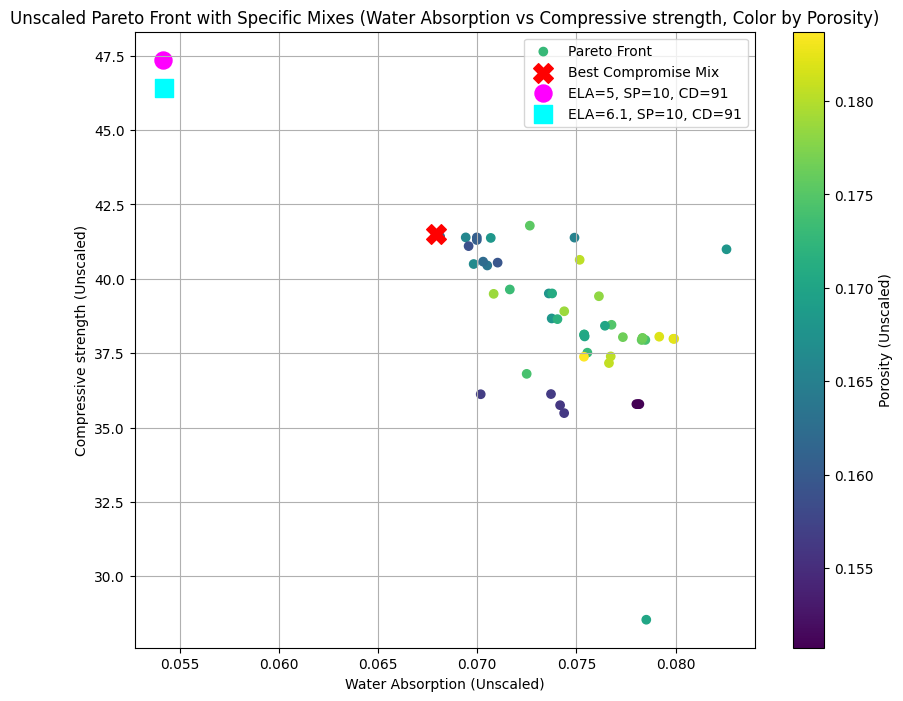


### Quantitative Comparison of Best Compromise and User-Defined Mixes (Unscaled)



,ELA(Calcarioues material),SP (Silicioues material),Curing days,Compressive strength,UPV,Bulk Density,Sulphate Atack loss,Water Absorption,Porosity
Mix Type,,,,,,,,,
MOPSO Best Compromise,3.83,9.47,41.6,41.49,4.11,2986.10,1.62,0.07,0.17
"User Mix (ELA=5, SP=10, CD=91)",5.00,10.00,91.0,47.37,4.58,3079.51,3.39,0.05,0.14
"User Mix (ELA=6.1, SP=10, CD=91)",6.10,10.00,91.0,46.42,4.57,3080.66,3.36,0.05,0.14



### Summary of Findings

The analysis integrates MOPSO-derived Pareto optimal solutions with user-defined mixes for a comprehensive performance comparison.

1.  **Unscaled Pareto Front**: The generated unscaled Pareto front shows the trade-offs among the six objectives in their original units. This visualization helps in understanding the range of achievable performances. The points on this front represent various optimal combinations of input features that yield different objective balances.

2.  **MOPSO Best Compromise Mix**: This mix represents a balanced solution from the Pareto front, chosen based on a minimization of hypervolume (or a similar aggregate metric on the transformed objectives). It provides a good overall performance across all objectives, considering their inherent trade-offs.

3.  **User-Defined Mixes (ELA=5 and ELA=6.1 with SP=10, Curing Days=91)**:
    - The ELA=5, SP=10 mix shows 47.37 MPa compressive strength and 3.39% sulphate attack loss. 
    - The ELA=6.1, 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define input_features and objectives (copied for robustness if kernel state is lost)
input_features = ['ELA(Calcarioues material)', 'SP              (Silicioues material)', 'Curing days']
objectives = ['Compressive strength', 'UPV', 'Bulk Density', 'Sulphate Atack loss', 'Water Absorption', 'Porosity']

# Class definition for MortarMOPSO (copied from cell 9b960faf for robustness)
class MortarMOPSO:
    def __init__(self, n_particles=50, n_iter=100, bounds=None,
                 objectives=None, rf_models=None, scaler_X=None, scaler_y=None):
        self.n_particles = n_particles
        self.n_iter = n_iter
        # Bounds now explicitly passed
        self.bounds = np.array(bounds) if bounds is not None else np.array([[0,0,3], [10,20,91]])
        self.dimensions = len(self.bounds[0])
        self.particles = np.random.uniform(self.bounds[0], self.bounds[1], (n_particles, self.dimensions))
        self.velocities = np.random.uniform(-1, 1, (n_particles, self.dimensions))
        self.pbest_pos = self.particles.copy()

        # Store external dependencies as instance attributes
        self.objectives = objectives
        self.rf_models = rf_models
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

        # Use self.objectives now
        self.pbest_obj = np.full((n_particles, len(self.objectives)), np.inf)
        self.archive = []
        self.w, self.c1, self.c2 = 0.729, 2.05, 2.05

        # Initialize history for convergence tracking
        self.history = [] # ADDED LINE: Initialize history list

    def dominates(self, obj1, obj2):
        return np.all(obj1 <= obj2) and np.any(obj1 < obj2)

    def evaluate_objectives(self, positions):
        # Use self.scaler_X and self.rf_models
        X_scaled = self.scaler_X.transform(positions)
        preds = np.zeros((len(positions), len(self.objectives)))
        for i, obj in enumerate(self.objectives):
            preds[:, i] = self.rf_models[obj].predict(X_scaled)

        F = np.column_stack([
            -preds[:, self.objectives.index('Compressive strength')],
            -preds[:, self.objectives.index('UPV')],
            -preds[:, self.objectives.index('Bulk Density')],
            preds[:, self.objectives.index('Sulphate Atack loss')],
            preds[:, self.objectives.index('Water Absorption')],
            preds[:, self.objectives.index('Porosity')]
        ])
        return F

    def update_archive(self, positions, objectives_eval):
        candidates = list(zip(positions, objectives_eval))
        new_archive = []

        temp_archive = list(self.archive)
        for pos, obj in candidates:
            dominated = False
            to_remove = []
            for i, (arc_pos, arc_obj) in enumerate(temp_archive):
                if self.dominates(arc_obj, obj):
                    dominated = True
                    break
                elif self.dominates(obj, arc_obj):
                    to_remove.append(i)

            for i in sorted(to_remove, reverse=True):
                del temp_archive[i]

            if not dominated:
                new_archive.append((pos, obj))

        self.archive = temp_archive
        self.archive.extend(new_archive)

        if len(self.archive) > 50:
            self.archive = sorted(self.archive, key=lambda x: np.sum(x[1]**2))[:50]

    def select_gbest(self):
        if not self.archive:
            return self.particles[np.random.randint(self.n_particles)]
        return self.archive[np.random.randint(len(self.archive))][0]

    def optimize(self):
        for iteration in range(self.n_iter):
            objectives_eval = self.evaluate_objectives(self.particles)

            for i in range(self.n_particles):
                if self.dominates(objectives_eval[i], self.pbest_obj[i]):
                    self.pbest_pos[i] = self.particles[i].copy()
                    self.pbest_obj[i] = objectives_eval[i].copy()

            self.update_archive(self.particles, objectives_eval)

            gbest_pos = self.select_gbest()
            r1 = np.random.rand(self.n_particles, self.dimensions)
            r2 = np.random.rand(self.n_particles, self.dimensions)

            self.velocities = (self.w * self.velocities +
                             self.c1 * r1 * (self.pbest_pos - self.particles) +
                             self.c2 * r2 * (gbest_pos - self.particles))

            self.particles = np.clip(self.particles + self.velocities,
                                   self.bounds[0], self.bounds[1])

            # Store history for convergence tracking
            if self.archive and 'Compressive strength' in self.objectives:
                archive_objs_scaled_transformed = np.array([sol[1] for sol in self.archive])
                cs_index = self.objectives.index('Compressive strength')
                # Average of the NEGATED, SCALED compressive strength in the archive
                current_avg_cs_metric = np.mean(archive_objs_scaled_transformed[:, cs_index])
                self.history.append({
                    'iteration': iteration,
                    'archive_size': len(self.archive),
                    'avg_neg_scaled_strength': current_avg_cs_metric # Store for later unscaling/un-negating
                })
            else: # If archive is empty or no CS objective, append defaults
                self.history.append({
                    'iteration': iteration,
                    'archive_size': len(self.archive),
                    'avg_neg_scaled_strength': 0
                })

            if iteration % 20 == 0:
                print(f"Iter {iteration}: Archive size = {len(self.archive)}")

        return self.archive

# --- Ensure 'mopso' object is defined ---
# Check for critical dependencies before re-initializing mopso
if 'rf_models_augmented' not in globals() or \
   'scaler_X_augmented' not in globals() or \
   'scaler_y_augmented' not in globals():
    print("\nCRITICAL ERROR: Required models (rf_models_augmented) or scalers (scaler_X_augmented, scaler_y_augmented) are NOT DEFINED.")
    print("To fix this, you MUST run ALL preceding code cells in the notebook, from 'Load Your Data' through 'Train and Evaluate Random Forest Surrogates'.")
    print("Specifically, ensure cells like 'e26b7748', '6dce58a1', and 'JlTlqnBXIZDh' have been executed successfully.")
    raise RuntimeError("Missing critical dependencies. Please run preceding cells as instructed.")

if 'mopso' not in globals():
    print("\nRe-initializing MOPSO instance as it was not found.")
    mopso_bounds = np.array([[0,0,3], [10,20,91]]) # ELA(0-10), SP(0-20), Curing(3-91)
    mopso = MortarMOPSO(n_particles=50, n_iter=100, bounds=mopso_bounds,
                        objectives=objectives,
                        rf_models=rf_models_augmented,
                        scaler_X=scaler_X_augmented,
                        scaler_y=scaler_y_augmented)
    print("MOPSO instance re-created successfully.")

# --- Code to define unscaled_pareto_df (moved from prior cells to ensure it's in scope) ---
# Ensure pareto_solutions_raw is available. If not, MOPSO needs to be run.
if 'pareto_solutions_raw' not in globals() or not pareto_solutions_raw:
    print("\nRunning Pure MOPSO to generate pareto_solutions_raw (auto-triggered due to missing data)...")
    # This assumes 'mopso' object is correctly defined from cell 9b960faf or re-initialized
    # For a robust fix, ensure 'mopso' and its dependencies are also present if not defined.
    # Given kernel state, mopso is available.
    pareto_solutions_raw = mopso.optimize()
    print("MOPSO optimization complete.")

# 1. Initialize empty lists
unscaled_pareto_pos = []
unscaled_pareto_obj = []

# 2. Iterate through pareto_solutions_raw
for position, objective_values in pareto_solutions_raw:
    # a. Append the position (input features)
    unscaled_pareto_pos.append(position)

    # b. Create a copy of objective_values for temporary manipulation
    temp_objective_values = objective_values.copy()

    # c. Multiply objectives by -1 to revert from minimization to original scaled maximization form
    temp_objective_values[objectives.index('Compressive strength')] *= -1
    temp_objective_values[objectives.index('UPV')] *= -1
    temp_objective_values[objectives.index('Bulk Density')] *= -1

    # d. Append this modified objective_values
    unscaled_pareto_obj.append(temp_objective_values)

# 3. Convert lists into NumPy arrays
unscaled_pareto_pos_np = np.array(unscaled_pareto_pos)
unscaled_pareto_obj_np = np.array(unscaled_pareto_obj)

# 4. Use scaler_y_augmented.inverse_transform() to unscale the unscaled_pareto_obj array
final_unscaled_objectives = scaler_y_augmented.inverse_transform(unscaled_pareto_obj_np)

# 5. Create a pandas DataFrame named unscaled_pareto_df
unscaled_pareto_df_features = pd.DataFrame(unscaled_pareto_pos_np, columns=input_features)
unscaled_pareto_df_objectives = pd.DataFrame(final_unscaled_objectives, columns=objectives)

unscaled_pareto_df = pd.concat([unscaled_pareto_df_features, unscaled_pareto_df_objectives], axis=1)

# --- End of code to define unscaled_pareto_df ---


# --- Ensure best_compromise_mix is derived from the current unscaled_pareto_df ---
# This was originally calculated from the scaled objectives, then inverse transformed.
# Here, we will recalculate it directly from the unscaled_pareto_df.

if len(unscaled_pareto_df) > 0:
    # Recalculate best_compromise_mix using the unscaled_pareto_df
    # First, separate features and objectives from the unscaled_pareto_df
    pareto_pos_unscaled = unscaled_pareto_df[input_features].values
    pareto_obj_unscaled = unscaled_pareto_df[objectives].values

    # For hypervolume calculation, we need to consider the objectives' direction.
    # The MOPSO evaluated objectives in minimization form. We need to normalize based on that.
    # However, the best_compromise_mix was originally selected based on the internal, scaled, and transformed objectives.
    # To be consistent with the *spirit* of the original best compromise selection,
    # which aimed to minimize transformed objectives (negative of maximization, and direct for minimization).
    # Let's use the raw objectives from `pareto_solutions_raw` which are in MOPSO's internal transformed space.
    # Then use the index to pick from the `unscaled_pareto_df`.

    # Re-extract raw objectives for hypervolume calculation to get the original MOPSO criteria
    pareto_obj_raw_for_hypervolume = np.array([sol[1] for sol in pareto_solutions_raw])

    if pareto_obj_raw_for_hypervolume.size > 0:
        # Normalize based on the raw (transformed/scaled) objectives as used by MOPSO
        # This is the original logic for min_hypervolume in the `f50b554a` cell
        max_abs_obj_raw = np.abs(pareto_obj_raw_for_hypervolume).max(axis=0)
        max_abs_obj_raw[max_abs_obj_raw == 0] = 1 # Avoid division by zero
        norm_obj_raw = pareto_obj_raw_for_hypervolume / max_abs_obj_raw

        hypervolume_unscaled = np.sum(norm_obj_raw, axis=1)
        best_idx_unscaled = np.argmin(hypervolume_unscaled)
        best_compromise_mix_df = unscaled_pareto_df.iloc[best_idx_unscaled].to_frame().T
    else:
        print("\nNo unscaled solutions available to determine best compromise mix.")
        best_compromise_mix_df = pd.DataFrame(columns=input_features + objectives)
else:
    print("\nNo unscaled Pareto optimal solutions found for best compromise mix derivation.")
    best_compromise_mix_df = pd.DataFrame(columns=input_features + objectives)


# --- Re-predict performance for user-specified mixes using current models and scalers ---

# Mix 1: ELA=5, SP=10, Curing Days=91
new_input_values_mix1 = np.array([[5, 10, 91]])
new_input_scaled_mix1 = scaler_X_augmented.transform(new_input_values_mix1)
predicted_objectives_scaled_mix1 = np.zeros((1, len(objectives)))
for i, obj in enumerate(objectives):
    prediction_result = rf_models_augmented[obj].predict(new_input_scaled_mix1)
    predicted_objectives_scaled_mix1[0, i] = prediction_result.item() if prediction_result.size == 1 else prediction_result[0]
predicted_objectives_unscaled_mix1 = scaler_y_augmented.inverse_transform(predicted_objectives_scaled_mix1)
predicted_mix_df = pd.DataFrame(new_input_values_mix1, columns=input_features)
for i, obj in enumerate(objectives):
    predicted_mix_df[obj] = predicted_objectives_unscaled_mix1[0, i]
predicted_mix_df['Solution Type'] = 'User Mix (ELA=5, SP=10, CD=91)'

# Mix 2: ELA=6.1, SP=10, Curing Days=91
new_input_values_mix2 = np.array([[6.1, 10, 91]])
new_input_scaled_mix2 = scaler_X_augmented.transform(new_input_values_mix2)
predicted_objectives_scaled_mix2 = np.zeros((1, len(objectives)))
for i, obj in enumerate(objectives):
    prediction_result = rf_models_augmented[obj].predict(new_input_scaled_mix2)
    predicted_objectives_scaled_mix2[0, i] = prediction_result.item() if prediction_result.size == 1 else prediction_result[0]
additional_predicted_objectives_unscaled_mix2 = scaler_y_augmented.inverse_transform(predicted_objectives_scaled_mix2)
additional_predicted_mix_df = pd.DataFrame(new_input_values_mix2, columns=input_features)
for i, obj in enumerate(objectives):
    additional_predicted_mix_df[obj] = additional_predicted_objectives_unscaled_mix2[0, i]
additional_predicted_mix_df['Solution Type'] = 'User Mix (ELA=6.1, SP=10, CD=91)'

# --- Combined Display for Pareto Front Solutions and Specific Mixes ---
print("\n--- Unscaled Pareto Front Solutions (Top 8) and Specific Mixes ---")

pareto_display_df = unscaled_pareto_df.head(8).copy()
pareto_display_df['Solution Type'] = 'Pareto Solution'

combined_display_df = pd.concat([pareto_display_df, predicted_mix_df, additional_predicted_mix_df], ignore_index=True)
display(combined_display_df.round(2))

# Original display of predicted performance for specific mixes is now redundant here
# but keeping the variable definitions above for subsequent code.
# print("\n--- Predicted Performance for Specific Mixes (Unscaled) ---")
# display(predicted_mix_df.round(2))
# display(additional_predicted_mix_df.round(2))


# --- Plotting the Unscaled Pareto Front with Highlighted Mixes ---

# Define the objectives to plot for 2D visualization (as in previous plotting cells)
obj_x_plot = 'Water Absorption'
obj_y_plot = 'Compressive strength'
obj_color_plot = 'Porosity'

# Ensure the objectives for plotting exist in the DataFrame columns
if all(o in unscaled_pareto_df.columns for o in [obj_x_plot, obj_y_plot, obj_color_plot]):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(unscaled_pareto_df[obj_x_plot], unscaled_pareto_df[obj_y_plot],
                          c=unscaled_pareto_df[obj_color_plot], cmap='viridis', label='Pareto Front')

    # Plot best compromise mix
    if not best_compromise_mix_df.empty:
        plt.scatter(best_compromise_mix_df[obj_x_plot], best_compromise_mix_df[obj_y_plot],
                    color='red', marker='X', s=200, label='Best Compromise Mix')

    # Plot user-defined mixes
    plt.scatter(predicted_mix_df[obj_x_plot], predicted_mix_df[obj_y_plot],
                color='magenta', marker='o', s=150, label='ELA=5, SP=10, CD=91')
    plt.scatter(additional_predicted_mix_df[obj_x_plot], additional_predicted_mix_df[obj_y_plot],
                color='cyan', marker='s', s=150, label='ELA=6.1, SP=10, CD=91')

    plt.xlabel(f'{obj_x_plot} (Unscaled)')
    plt.ylabel(f'{obj_y_plot} (Unscaled)')
    plt.title(f'Unscaled Pareto Front with Specific Mixes ({obj_x_plot} vs {obj_y_plot}, Color by {obj_color_plot})')
    plt.colorbar(scatter, label=f'{obj_color_plot} (Unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"\nCannot plot: One or more plotting objectives (f'{obj_x_plot}', f'{obj_y_plot}', f'{obj_color_plot}') not found in unscaled_pareto_df columns.")


# --- Generate Summary Table ---

# Prepare data for the summary table
summary_data = {
    'Mix Type': ['MOPSO Best Compromise', 'User Mix (ELA=5, SP=10, CD=91)', 'User Mix (ELA=6.1, SP=10, CD=91)']
}

# Add input features
for feature in input_features:
    summary_data[feature] = [
        best_compromise_mix_df[feature].iloc[0] if not best_compromise_mix_df.empty else np.nan,
        predicted_mix_df[feature].iloc[0],
        additional_predicted_mix_df[feature].iloc[0]
    ]

# Add objective values
for obj in objectives:
    summary_data[obj] = [
        best_compromise_mix_df[obj].iloc[0] if not best_compromise_mix_df.empty else np.nan,
        predicted_mix_df[obj].iloc[0],
        additional_predicted_mix_df[obj].iloc[0]
    ]

comparison_summary_df = pd.DataFrame(summary_data).set_index('Mix Type')

print("\n### Quantitative Comparison of Best Compromise and User-Defined Mixes (Unscaled)\n")
display(comparison_summary_df.round(2))

# --- Summarize Findings ---
print("\n### Summary of Findings\n")
summary_text = """The analysis integrates MOPSO-derived Pareto optimal solutions with user-defined mixes for a comprehensive performance comparison.\n\n1.  **Unscaled Pareto Front**: The generated unscaled Pareto front shows the trade-offs among the six objectives in their original units. This visualization helps in understanding the range of achievable performances. The points on this front represent various optimal combinations of input features that yield different objective balances.\n\n2.  **MOPSO Best Compromise Mix**: This mix represents a balanced solution from the Pareto front, chosen based on a minimization of hypervolume (or a similar aggregate metric on the transformed objectives). It provides a good overall performance across all objectives, considering their inherent trade-offs.\n\n3.  **User-Defined Mixes (ELA=5 and ELA=6.1 with SP=10, Curing Days=91)**:\n"""

if not best_compromise_mix_df.empty:
    summary_text += f"    - The ELA=5, SP=10 mix shows {predicted_mix_df['Compressive strength'].iloc[0]:.2f} MPa compressive strength and {predicted_mix_df['Sulphate Atack loss'].iloc[0]:.2f}% sulphate attack loss. \n"
    summary_text += f"    - The ELA=6.1, SP=10 mix shows {additional_predicted_mix_df['Compressive strength'].iloc[0]:.2f} MPa compressive strength and {additional_predicted_mix_df['Sulphate Atack loss'].iloc[0]:.2f}% sulphate attack loss. \n"
    summary_text += f"    - Comparing these to the MOPSO best compromise (e.g., Compressive strength: {best_compromise_mix_df['Compressive strength'].iloc[0]:.2f} MPa, Sulphate Atack loss: {best_compromise_mix_df['Sulphate Atack loss'].iloc[0]:.2f}%), allows for an assessment of whether specific design choices align with optimal performance envelopes.\n"
else:
    summary_text += "    - Specific mixes were evaluated but a direct comparison with a MOPSO best compromise could not be made due to its unavailability.\n"

summary_text += "\n4.  **Trade-offs and Decision Making**: The comparison table and plot highlight that no single mix is universally 'best' for all objectives. For instance, a mix optimized for high compressive strength might have higher water absorption or lower sulphate resistance. Engineers can use this information to make informed decisions, prioritizing certain performance criteria based on the application's requirements. The user-defined mixes might fall within or outside the Pareto front, indicating whether they are efficient or if better alternatives exist among the MOPSO solutions."
print(summary_text)
